<a href="https://colab.research.google.com/github/pr1me1/learning_lab/blob/master/practise/custom_datasets/flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle torch
!pip install pillow
!pip install torchinfo
!pip install tqdm

In [2]:
!export KAGGLE_API_TOKEN=KGAT_23646b633759593115b2c132f4cbf8c3

In [3]:
import kagglehub
from pathlib import Path

path = kagglehub.dataset_download("imsparsh/flowers-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'flowers-dataset' dataset.
Path to dataset files: /kaggle/input/flowers-dataset


In [4]:
!mkdir -p /content/fruits
!cp -r {path}/* /content/fruits/

set_dir = Path("/content/fruits")

In [5]:
import os

def walk_through_dir(target_dir: Path):
  for dirpath, dirnames, filenames in os.walk(target_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


walk_through_dir(Path(set_dir))

There are 2 directories and 3 images in '/content/fruits'.
There are 5 directories and 0 images in '/content/fruits/train'.
There are 0 directories and 501 images in '/content/fruits/train/daisy'.
There are 0 directories and 497 images in '/content/fruits/train/rose'.
There are 0 directories and 495 images in '/content/fruits/train/sunflower'.
There are 0 directories and 607 images in '/content/fruits/train/tulip'.
There are 0 directories and 646 images in '/content/fruits/train/dandelion'.
There are 0 directories and 924 images in '/content/fruits/test'.


In [6]:
main_set_path = set_dir / "train"

main_set_path.exists()

True

In [7]:
test_set_path = set_dir / "test"

test_set_path.exists()

True

In [34]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from PIL import Image
import random

class CustomDataset(Dataset):
  def __init__(self, target_dir, transforms = None, split_ratio = 0.8, is_train_split = True, glob_pattern = "*/*.jpg", known_class_names=None):
    self.transforms = transforms
    self.is_train_split = is_train_split
    all_paths = list(Path(target_dir).glob(glob_pattern))


    if is_train_split is not None:
      split_idx = int(len(all_paths) * split_ratio)
      random.shuffle(all_paths)
      if is_train_split:
        self.paths = all_paths[:split_idx]
      else:
        self.paths = all_paths[split_idx:]
      self.class_names = sorted(entry.name for entry in target_dir.iterdir() if entry.is_dir())
    else:
      self.paths = all_paths
      self.class_names = known_class_names if known_class_names else []

    self.class_idx = {name: idx for idx, name in enumerate(self.class_names)}


  def __len__(self):
    return len(self.paths)


  def load_image(self, idx: int):
    image_path = self.paths[idx]
    return Image.open(image_path)


  def __getitem__(self, index: int):
    img = self.load_image(index)

    if self.transforms:
      img = self.transforms(img)

    if self.is_train_split is not None:
      class_name = self.paths[index].parent.name
      class_idx = self.class_idx[class_name]
    else:
      class_idx = -1

    return img, class_idx


In [9]:
train_transforms = transforms.Compose([
  transforms.Resize((192, 192)),
  # transforms.TrivialAugmentWide(),
  transforms.ToTensor()
])

test_transforms = transforms.Compose([
  transforms.Resize((192, 192)),
  transforms.ToTensor()
])

train_set = CustomDataset(main_set_path, transforms=train_transforms, is_train_split=True)

validation_set = CustomDataset(main_set_path, transforms=train_transforms, is_train_split=False)

class_names = train_set.class_names
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

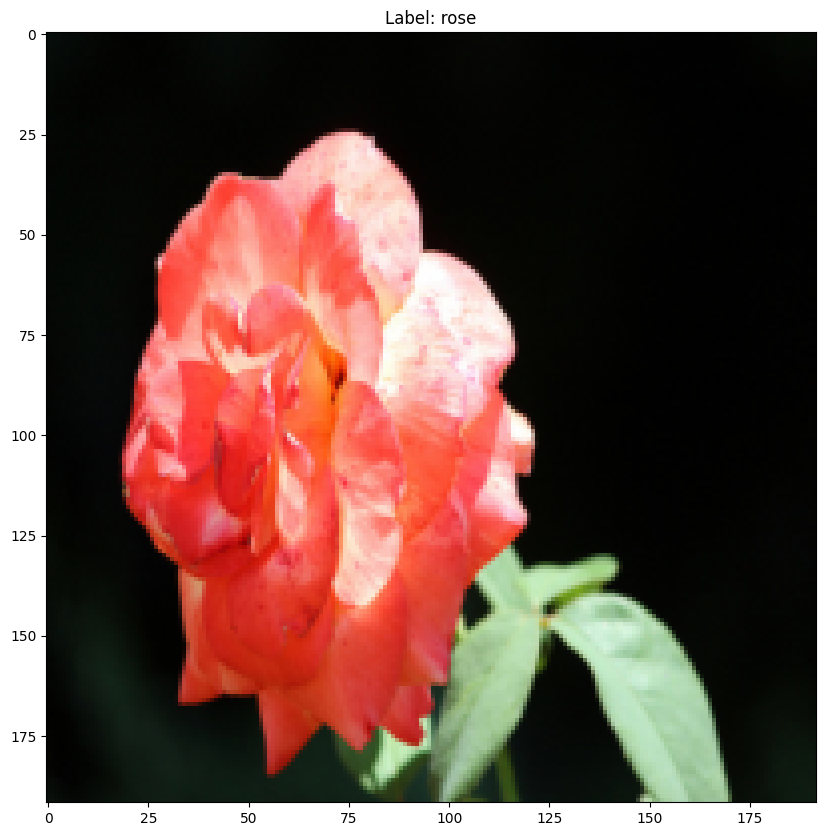

In [10]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))

img, label = train_set[32]
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Label: {class_names[label]}")
plt.show()

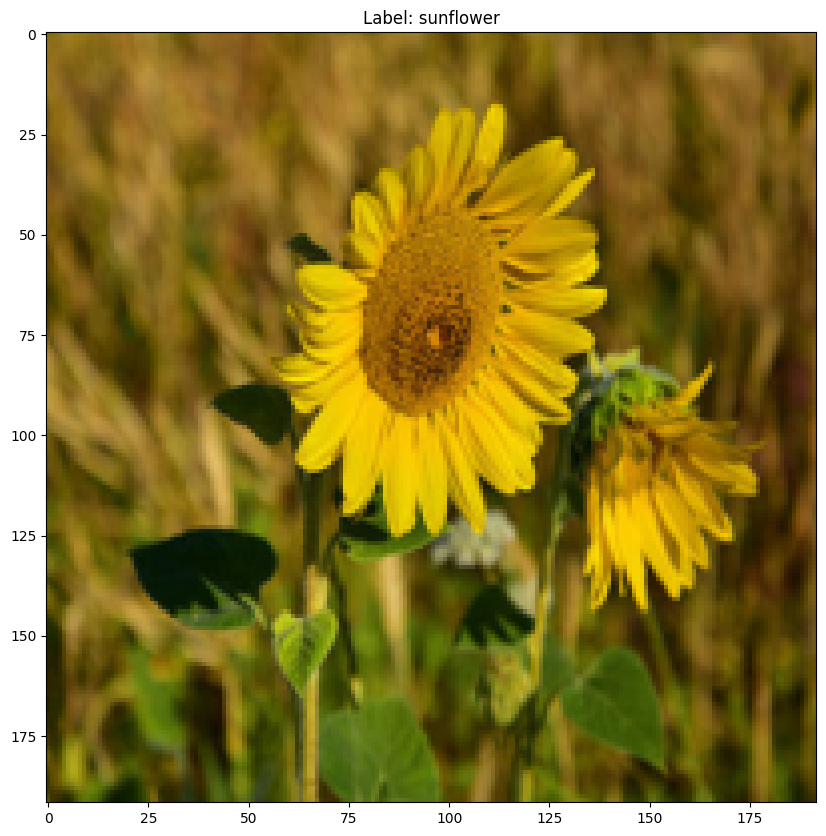

In [11]:
plt.figure(figsize=(10, 10))

img, label = validation_set[32]
plt.imshow(img.permute(1,2,0))
plt.title(f"Label: {class_names[label]}")
plt.show()

In [12]:
train_set, validation_set

(<__main__.CustomDataset at 0x79e3093c3cb0>,
 <__main__.CustomDataset at 0x79e425f2d0d0>)

In [13]:
len(train_set), len(validation_set)

(2196, 550)

In [14]:
img.shape

torch.Size([3, 192, 192])

In [15]:
from torch.utils.data import DataLoader

BATCH_SIZE = 4

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
)

validation_loader = DataLoader(
    validation_set,
    batch_size=2*BATCH_SIZE,
    shuffle=False,
)

train_loader, validation_loader

(<torch.utils.data.dataloader.DataLoader at 0x79e3090d4b90>,
 <torch.utils.data.dataloader.DataLoader at 0x79e308fda5a0>)

In [16]:
from torch import nn
from torchinfo import summary

class TinyVGG(nn.Module):
  def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=input_size, out_channels=hidden_size, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_size*48*48, out_features=output_size)
    )

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.squeeze()
    return self.classifier(x)


model = TinyVGG(img.shape[0], 32, len(class_names))
summary(model, input_size=(32, img.shape[0], img.shape[1], img.shape[2]))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 5]                   --
├─Sequential: 1-1                        [32, 32, 96, 96]          --
│    └─Conv2d: 2-1                       [32, 32, 192, 192]        896
│    └─ReLU: 2-2                         [32, 32, 192, 192]        --
│    └─Conv2d: 2-3                       [32, 32, 192, 192]        9,248
│    └─ReLU: 2-4                         [32, 32, 192, 192]        --
│    └─MaxPool2d: 2-5                    [32, 32, 96, 96]          --
├─Sequential: 1-2                        [32, 32, 48, 48]          --
│    └─Conv2d: 2-6                       [32, 32, 96, 96]          9,248
│    └─ReLU: 2-7                         [32, 32, 96, 96]          --
│    └─Conv2d: 2-8                       [32, 32, 96, 96]          9,248
│    └─ReLU: 2-9                         [32, 32, 96, 96]          --
│    └─MaxPool2d: 2-10                   [32, 32, 48, 48]          --
├─Seq

In [17]:
import torch

def accuracy_fn(y_true, y_pred):
  equals = torch.eq(y_true, y_pred).sum().item()
  return (equals / len(y_pred)) * 100

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [20]:
def train_steps(
    dataloader,
    model,
    loss_fn,
    optimizer,
    acc_fn,
    device = device
):
  train_loss, train_acc = 0, 0
  model.to(device)
  for batch, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)
    logits = model(x)
    loss = loss_fn(logits, y)
    train_loss += loss.item()
    train_acc += acc_fn(y, logits.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc


In [21]:
def validation_steps(
    dataloader,
    model,
    loss_fn,
    acc_fn,
    device = device
):
  validation_loss, validation_acc = 0, 0
  model.to(device)
  with torch.inference_mode():
    for batch, (x, y) in enumerate(dataloader):
      x, y = x.to(device), y.to(device)
      logits = model(x)
      loss = loss_fn(logits, y)
      validation_loss += loss.item()
      validation_acc += acc_fn(y, logits.argmax(dim=1))
  validation_loss /= len(dataloader)
  validation_acc /= len(dataloader)
  return validation_loss, validation_acc

In [22]:
def eval_model(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    acc_fn: nn.Module,
    device = device
):
  model.to(device)
  loss, acc = 0, 0
  with torch.inference_mode():
    for x, y in dataloader:
      x, y = x.to(device), y.to(device)
      logits = model(x)
      loss += loss_fn(logits, y)
      acc += acc_fn(y, logits.argmax(dim=1))
    loss /= len(dataloader)
    acc /= len(dataloader)

  return {
      "model": model.__class__.__name__,
      "loss": loss.item(),
      "accuracy": acc
  }

In [23]:
from tqdm.auto import tqdm

def train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_fn,
    acc_fn,
    epochs,
    device = device
):
  results = {
      "train_loss": [],
      "train_acc": [],
      "validation_loss": [],
      "validation_acc": []
  }

  for epoch in range(epochs):
    train_loss, train_acc = train_steps(
        train_dataloader,
        model,
        loss_fn,
        optimizer,
        acc_fn,
        device,
    )
    validation_loss, validation_acc = validation_steps(
        test_dataloader,
        model,
        loss_fn,
        acc_fn,
        device
    )

    print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f}% | "
            f"validation_loss: {validation_loss:.4f} | "
            f"validation_acc: {validation_acc:.4f}%"
    )

    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["validation_loss"].append(validation_loss.item() if isinstance(validation_loss, torch.Tensor) else validation_loss)
    results["validation_acc"].append(validation_acc.item() if isinstance(validation_acc, torch.Tensor) else validation_acc)

  return results

In [24]:
# torch.backends.cudnn.benchmark = True

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 10
model_results = train(
    model,
    train_loader,
    validation_loader,
    optimizer,
    loss_fn,
    accuracy_fn,
    epochs
)

Epoch: 1 | train_loss: 1.6133 | train_acc: 23.3151% | validation_loss: 1.5760 | validation_acc: 28.3213%
Epoch: 2 | train_loss: 1.5498 | train_acc: 28.8707% | validation_loss: 1.3296 | validation_acc: 42.9348%
Epoch: 3 | train_loss: 1.3155 | train_acc: 44.6266% | validation_loss: 1.0950 | validation_acc: 57.1860%
Epoch: 4 | train_loss: 0.9979 | train_acc: 61.9308% | validation_loss: 0.7749 | validation_acc: 71.0145%
Epoch: 5 | train_loss: 0.6658 | train_acc: 75.8197% | validation_loss: 0.5652 | validation_acc: 81.5217%
Epoch: 6 | train_loss: 0.3945 | train_acc: 86.7942% | validation_loss: 0.4616 | validation_acc: 88.5870%
Epoch: 7 | train_loss: 0.1807 | train_acc: 94.5811% | validation_loss: 0.3967 | validation_acc: 90.3986%
Epoch: 8 | train_loss: 0.1200 | train_acc: 96.1749% | validation_loss: 0.5350 | validation_acc: 91.3043%
Epoch: 9 | train_loss: 0.0982 | train_acc: 97.0401% | validation_loss: 0.5716 | validation_acc: 89.8551%
Epoch: 10 | train_loss: 0.1155 | train_acc: 97.1767% | 

In [26]:
from typing import Dict, List, Tuple

def plot_curve_function(
    results: Dict[str, List[float]]
):
  train_loss = results["train_loss"]
  test_loss = results["validation_loss"]

  train_acc = results["train_acc"]
  test_acc = results["validation_acc"]

  epochs = range(len(results["validation_acc"]))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label='train_loss')
  plt.plot(epochs, test_loss, label='validation_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, train_acc, label='train_acc')
  plt.plot(epochs, test_acc, label='validation_acc')
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

  plt.show()


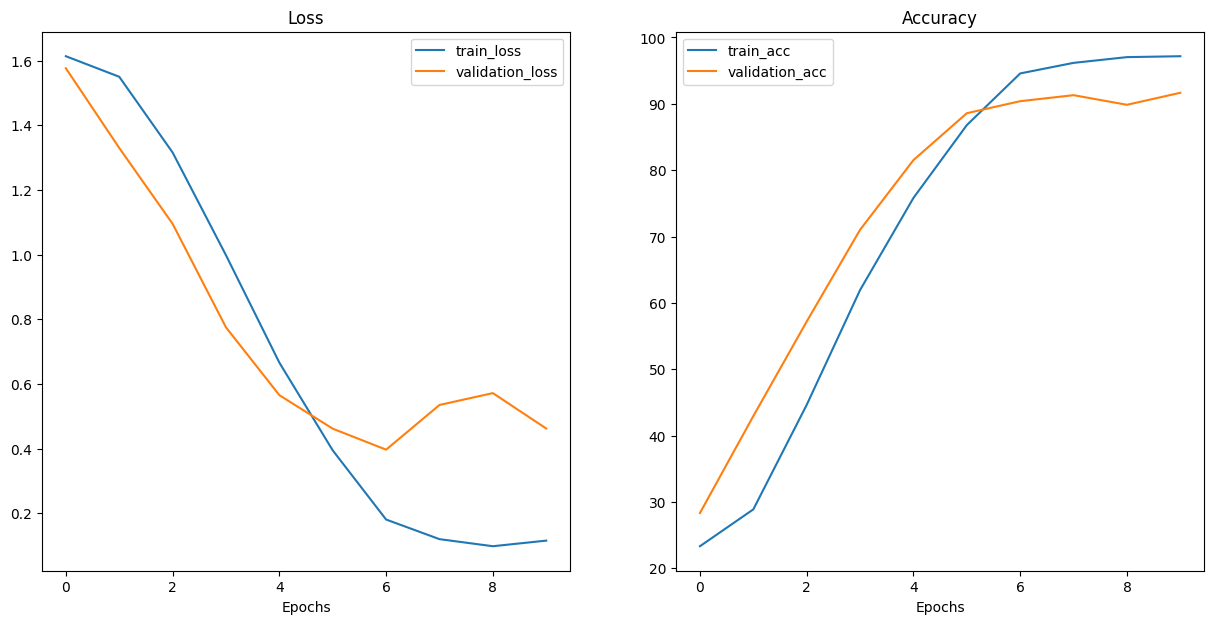

In [27]:
plot_curve_function(model_results)

In [35]:
test_dataset = CustomDataset(
    target_dir=test_set_path,
    transforms=test_transforms,
    is_train_split=None,
    known_class_names=class_names,
    glob_pattern="*.jpg"
)


test_dataset, len(test_dataset), test_set_path

(<__main__.CustomDataset at 0x79e2fef54e00>,
 924,
 PosixPath('/content/fruits/test'))

In [36]:
test_loader = DataLoader(
    test_dataset,
    batch_size=2*BATCH_SIZE,
    shuffle=False
)

len(test_loader)

116

In [37]:
sample = next(iter(test_loader))
sample[0].shape, sample[1].shape

(torch.Size([8, 3, 192, 192]), torch.Size([8]))

In [38]:
test_predictions = []

model.to(device)
for batch, (x, y) in enumerate(test_loader):
  x, y = x.to(device), y.to(device)
  with torch.inference_mode():
    logits = model(x)
    test_predictions += logits.argmax(dim=1).tolist()

test_predictions[:10]

[2, 2, 1, 2, 4, 1, 4, 1, 2, 2]

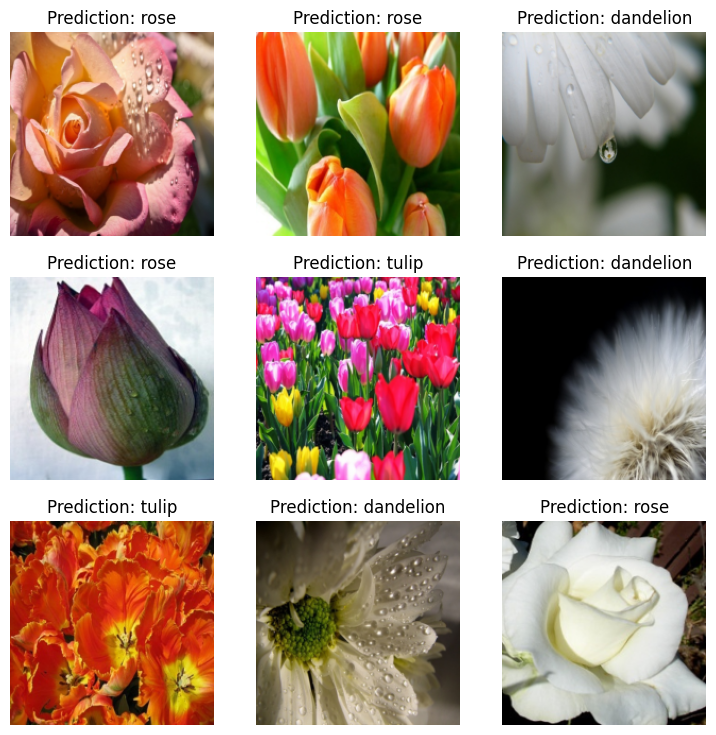

In [39]:
def display_test(
    loader,
    predcitions,
):
  plt.figure(figsize=(9, 9))
  nrows = 3
  ncols = 3
  for i, (image_batch, labels_batch) in enumerate(loader):
    for j in range(min(image_batch.shape[0], nrows * ncols - i * image_batch.shape[0])):
      if (i * image_batch.shape[0] + j) >= len(predcitions):
          break

      img = image_batch[j].to("cpu")
      img_display = img.permute(1, 2, 0)

      plt.subplot(nrows, ncols, i * image_batch.shape[0] + j + 1)
      plt.imshow(img_display)
      predicted_label_index = predcitions[i * image_batch.shape[0] + j]
      plt.title(f"Prediction: {class_names[predicted_label_index]}")
      plt.axis(False)
  plt.show()


display_test(test_loader, test_predictions)